# Conditional GAN

In [28]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../../data/mnist', train=True, transform=transform, download=False)

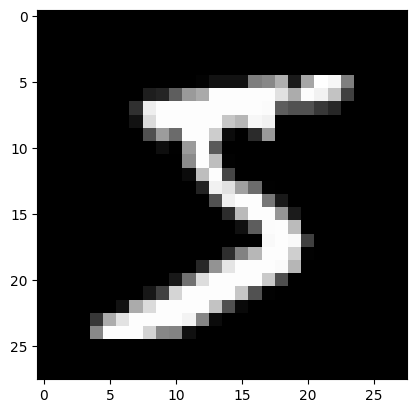

In [3]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

In [13]:
def show_images(images, nrow=8, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid((images + 1) / 2, nrow=nrow).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

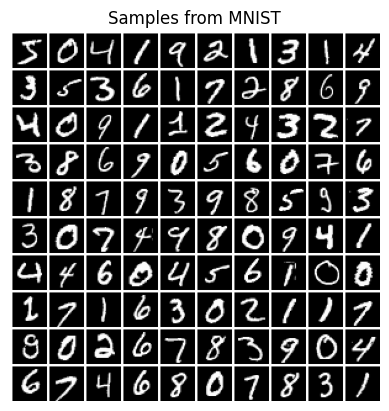

In [16]:
show_images(torch.stack([dataset[i][0] for i in range(100)]), nrow=10, title='Samples from MNIST');

In [91]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, img_channels):
        super().__init__()

        self.net = nn.Sequential(
            self.__basic_block(in_channels=input_dim, out_channels=hidden_dim*4, kernel_size=3, stride=1),
            self.__basic_block(in_channels=hidden_dim*4, out_channels=hidden_dim*2, kernel_size=4, stride=1),
            self.__basic_block(in_channels=hidden_dim*2, out_channels=hidden_dim, kernel_size=3, stride=2),
            nn.ConvTranspose2d(hidden_dim, img_channels, kernel_size=4, stride=2),
            nn.Tanh(),
        )
    
    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)

In [19]:
noise = torch.randn(1, 100, 1, 1)
Generator(100, 64, 1)(noise).shape

torch.Size([1, 1, 28, 28])

In [18]:
class Discriminative(nn.Module):
    def __init__(self, input_channels, hidden_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            self.__basic_block(input_channels, hidden_dim, kernel_size=4, stride=2),
            self.__basic_block(hidden_dim, hidden_dim*2, kernel_size=4, stride=2),
            nn.Conv2d(hidden_dim*2, 1, kernel_size=4, stride=2),
        )

    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x):
        return self.net(x).view(x.size(0), 1)

In [20]:
x = torch.randn(32, 1, 28, 28)
Discriminative(1, 1)(x).shape

torch.Size([32, 1])

In [42]:
FLATTENED_IMAGE_SIZE = dataset[0][0].numel()
NOISE_DIM = 64
BATCH_SIZE = 128
NUM_EPOCHS = 30
NUM_CLASSES = 10
IMG_SIZE = (28, 28)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [22]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [92]:
gen = Generator(input_dim=NOISE_DIM+NUM_CLASSES, hidden_dim=64, img_channels=1).to(device).apply(init_weights)
disc = Discriminative(input_channels=1+NUM_CLASSES, hidden_dim=16).to(device).apply(init_weights)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.BCEWithLogitsLoss()

opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

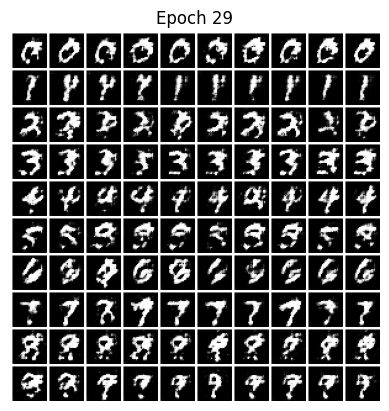

In [93]:
fixed_noise = torch.randn(100, NOISE_DIM, 1, 1).to(device)
fixed_labels = torch.arange(10).view(10, 1).repeat(1, 10).flatten().to(device)
fixed_labels_one_hot = F.one_hot(fixed_labels, num_classes=NUM_CLASSES)
fixed_noise_and_labels = torch.cat((fixed_noise, fixed_labels_one_hot[:, :, None, None]), dim=1)

images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for epoch in range(NUM_EPOCHS):
    for real_images, labels in dataloader:
        real_images, labels = real_images.to(device), labels.to(device)

        batch_size = real_images.size(0)

        one_hot_labels = F.one_hot(labels, num_classes=NUM_CLASSES)[:, :, None, None]
        image_one_hot_labels = one_hot_labels.repeat(1, 1, *IMG_SIZE)

        real_images_and_labels = torch.cat((real_images, image_one_hot_labels), dim=1)

        #----- Updating the Discriminator -----#
        noise = torch.randn(batch_size, NOISE_DIM, 1, 1).to(device)
        noise_and_one_hot_labels = torch.cat((noise, one_hot_labels), dim=1)
        fake_images = gen(noise_and_one_hot_labels).detach()
        fake_images_and_labels = torch.cat((fake_images, image_one_hot_labels), dim=1)
        fake_loss = criterion(disc(fake_images_and_labels), torch.zeros(batch_size, 1).to(device))
        real_loss = criterion(disc(real_images_and_labels), torch.ones(batch_size, 1).to(device))
        loss = (fake_loss + real_loss) / 2
        disc.zero_grad()
        loss.backward()
        opt_disc.step()

        #----- Updating the Generator -----#
        noise = torch.randn(batch_size, NOISE_DIM, 1, 1).to(device)
        noise_and_one_hot_labels = torch.cat((noise, one_hot_labels), dim=1)
        fake_images = gen(noise_and_one_hot_labels)
        fake_images_and_labels = torch.cat((fake_images, image_one_hot_labels), dim=1)
        loss = criterion(disc(fake_images_and_labels), torch.ones(batch_size, 1).to(device))
        gen.zero_grad()
        loss.backward()
        opt_gen.step()

    clear_output()
    show_images(gen(fixed_noise_and_labels).detach().cpu(), nrow=10, title=f"Epoch {epoch}")
    images.append(transf(torchvision.utils.make_grid((gen(fixed_noise_and_labels) + 1) / 2, nrow=10).detach().cpu()))


# Conditional Wasserstein GAN with Gradient Penalty + nn.Embedding

In [111]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, hidden_dim, img_channels):
        super().__init__()

        self.embd = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            self.__basic_block(in_channels=z_dim+num_classes, out_channels=hidden_dim*4, kernel_size=3, stride=1),
            self.__basic_block(in_channels=hidden_dim*4, out_channels=hidden_dim*2, kernel_size=4, stride=1),
            self.__basic_block(in_channels=hidden_dim*2, out_channels=hidden_dim, kernel_size=3, stride=2),
            nn.ConvTranspose2d(hidden_dim, img_channels, kernel_size=4, stride=2),
            nn.Tanh(),
        )
    
    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, noise, labels):
        noise_and_labels = torch.cat((noise, self.embd(labels)), dim=1)[:, :, None, None]
        return self.net(noise_and_labels)

In [112]:
class Critic(nn.Module):
    def __init__(self, img_channels, num_classes, img_size, hidden_dim):
        super().__init__()

        self.img_size = img_size
        
        self.embd = nn.Embedding(num_classes, img_size[0]*img_size[1])

        self.net = nn.Sequential(
            self.__basic_block(img_channels+1, hidden_dim, kernel_size=4, stride=2),
            self.__basic_block(hidden_dim, hidden_dim*2, kernel_size=4, stride=2),
            nn.Conv2d(hidden_dim*2, 1, kernel_size=4, stride=2),
        )

    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x, labels):
        labels_embd = self.embd(labels).view(labels.shape[0], 1, self.img_size[0], self.img_size[1])
        images_and_labels = torch.cat((x, labels_embd), dim=1)
        return self.net(images_and_labels).view(x.size(0), 1)

In [128]:
NOISE_DIM = 100
BATCH_SIZE = 64
NUM_EPOCHS = 20
NUM_CRITIC_UPDATE = 5
GP_LAMBDA = 10

In [129]:
def calc_gradient_penalty(critic, real_images, fake_images, labels):
    eps = torch.rand((real_images.size(0), *(1 for _ in range(len(real_images.shape) - 1))), requires_grad=True).to(device)
    intermediate_images = eps * real_images + (1 - eps) * fake_images
    scores = critic(intermediate_images, labels)
    gradients = torch.autograd.grad(outputs=scores, inputs=intermediate_images, grad_outputs=torch.ones_like(scores), create_graph=True, retain_graph=True)[0]
    gradients_norm = torch.norm(gradients.view(gradients.shape[0], -1), dim=1)
    gp = torch.mean((gradients_norm - 1) ** 2)
    return gp

In [130]:
gen = Generator(z_dim=NOISE_DIM, num_classes=NUM_CLASSES, hidden_dim=64, img_channels=1).to(device).apply(init_weights)
crit = Critic(img_channels=1, num_classes=NUM_CLASSES, img_size=IMG_SIZE, hidden_dim=16).to(device).apply(init_weights)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_crit = torch.optim.Adam(crit.parameters(), lr=0.0002, betas=(0.5, 0.999))

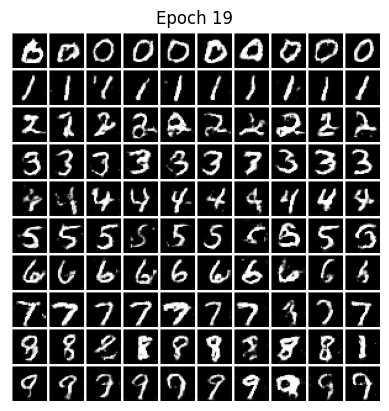

In [131]:
fixed_noise = torch.randn(100, NOISE_DIM).to(device)
fixed_labels = torch.arange(10).repeat_interleave(10).to(device)

images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for epoch in range(NUM_EPOCHS):
    for real_images, labels in dataloader:
        real_images, labels = real_images.to(device), labels.to(device)
        batch_size = real_images.size(0)

        #----- Updating the Discriminator -----#
        for _ in range(NUM_CRITIC_UPDATE):
            noise = torch.randn(batch_size, NOISE_DIM).to(device)
            fake_images = gen(noise, labels).detach()
            loss = -torch.mean(crit(real_images, labels)) + torch.mean(crit(fake_images, labels)) + GP_LAMBDA*calc_gradient_penalty(crit, real_images, fake_images, labels)
            crit.zero_grad()
            loss.backward(retain_graph=True)
            opt_crit.step()

        #----- Updating the Generator -----#
        noise = torch.randn(batch_size, NOISE_DIM).to(device)
        loss = -torch.mean(crit(gen(noise, labels), labels))
        gen.zero_grad()
        loss.backward()
        opt_gen.step()

    clear_output()
    show_images(gen(fixed_noise, fixed_labels).detach().cpu(), nrow=10, title=f"Epoch {epoch}")
    images.append(transf(torchvision.utils.make_grid((gen(fixed_noise, fixed_labels) + 1) / 2, nrow=10).detach().cpu()))


In [132]:
import cv2

video = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 5, (240, 240), False)
for image in images:
    video.write(image)
video.release()
cv2.destroyAllWindows()

In [133]:
import imageio

imageio.mimsave('output.gif', images, fps=5)

![](output.gif)

## Exploring the Learned Representation (Z) and Class Embeddings

In [190]:
gen.eval();

### Fixed label - Variable noise

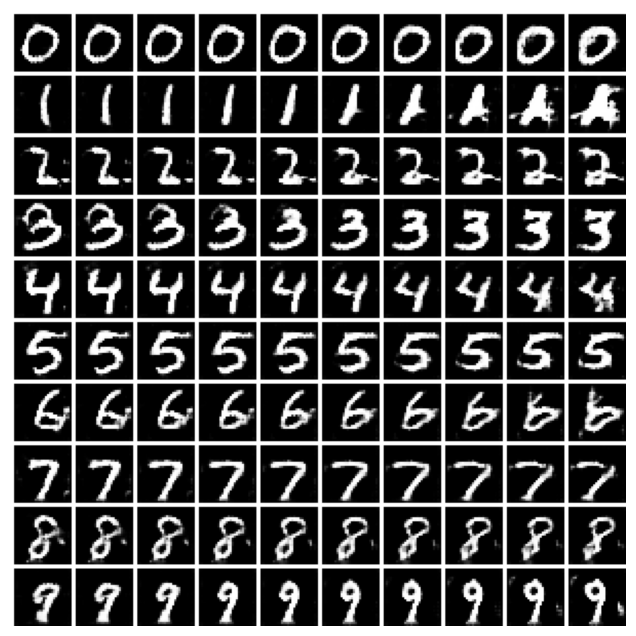

In [300]:
first_noises, second_noises = [torch.randn(10, NOISE_DIM).to(device) for _ in range(2)]
labels = torch.arange(10).repeat_interleave(10).to(device)

########## Generating Interpolated Noises - Method #1 ##########
# percent_space, inv_percent_space = [torch.zeros((100, 10), device=device) for _ in range(2)]
# for i in range(10):
#     percent_space[10*i:10*(i+1), i] = torch.linspace(0, 1, 10)
#     inv_percent_space[10*i:10*(i+1), i] = 1 - torch.linspace(0, 1, 10)
# interpolated_noises = percent_space @ first_noises + inv_percent_space @ second_noises

########## Generating Interpolated Noises - Method #2 ##########
# percent_space = torch.linspace(0, 1, 10).view(10, 1).to(device)
# interpolated_noises = []
# for first_noise, second_noise in zip(first_noises, second_noises):
#     interpolated_noises.append(percent_space * first_noise[None, :] + (1 - percent_space) * second_noise[None, :])
# interpolated_noises = torch.cat(interpolated_noises, dim=0)

########## Generating Interpolated Noises - Method #3 ##########
percent_space = torch.linspace(0, 1, 10).view(1, 10, 1).repeat(10, 1, 1).to(device)
interpolated_noises = (percent_space @ first_noises.unsqueeze(1) + (1 - percent_space) @ second_noises.unsqueeze(1)).flatten(0, 1)

plt.figure(figsize=(8, 8))
show_images(gen(interpolated_noises, labels).detach().cpu(), nrow=10)

### Variable label - Fixed noise

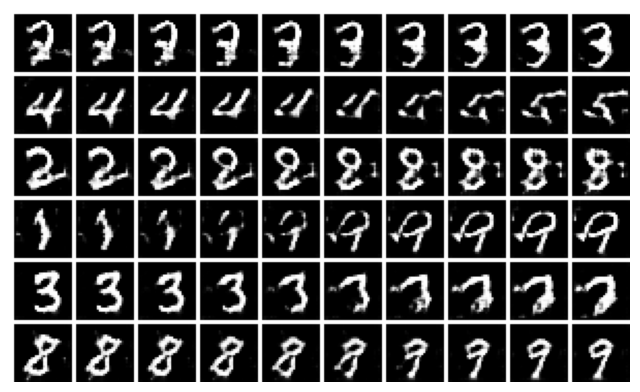

In [371]:
pairs = [(2, 3), (4, 5), (2, 8), (1, 9), (3, 7), (8, 9)]
first_embd = gen.embd(torch.tensor([p[0] for p in pairs], device=device)).unsqueeze(1)
second_embd = gen.embd(torch.tensor([p[1] for p in pairs], device=device)).unsqueeze(1)
n_samples = first_embd.size(0)

noise = torch.randn(n_samples, NOISE_DIM).repeat_interleave(10, dim=0).to(device)
percent_space = torch.linspace(0, 1, 10)[None, :, None].repeat(n_samples, 1, 1).to(device)
interpolated_embd = (percent_space @ second_embd + (1 - percent_space) @ first_embd).flatten(0, 1)
noise_and_labels = torch.cat((noise, interpolated_embd), dim=1)[:, :, None, None]

plt.figure(figsize=(8, 8))
show_images(gen.net(noise_and_labels).detach().cpu(), nrow=10)